In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import itertools
from statistics import mean
import statsmodels.api as sm
from statsmodels.formula.api import ols
import json

In [102]:
with open('test_result.json') as json_file:
    test_result = json.load(json_file)

In [65]:
data_DO = pd.DataFrame(columns=['Query_ID', 'ExecutionTime', 'Context'])

In [66]:
for context in ["druid", "omnisci"]:
    for query, timings in test_result["timings"][context].items():
        # print(f"Adding {query} with values {timings}")
        for timing in timings:
            # print(f"Inserted row is: [{query}, {timing}, {context}]")
            data_DO = data_DO.append({'Query_ID': query, 'ExecutionTime': timing, 'Context': context}, ignore_index=True)
        # print("Done")
        # print(data_DO)

In [67]:
data_DO

,Query_ID,ExecutionTime,Context
0,Q1,0.420828,druid
1,Q1,0.394000,druid
2,Q1,0.576804,druid
3,Q1,0.384480,druid
4,Q1,0.563681,druid
...,...,...,...
477,Q9,0.847989,omnisci
478,Q9,0.832185,omnisci
479,Q9,0.839815,omnisci
480,Q9,0.859804,omnisci


In [68]:
for x, group in data_DO.groupby("Query_ID"):
    group_mean = group.query("Context == 'druid'")["ExecutionTime"].mean()
    group = group.eval("ExecutionTimeSTD = ExecutionTime / @group_mean")
    data_DO.loc[group.index, "ExecutionTimeSTD"] = group["ExecutionTimeSTD"]

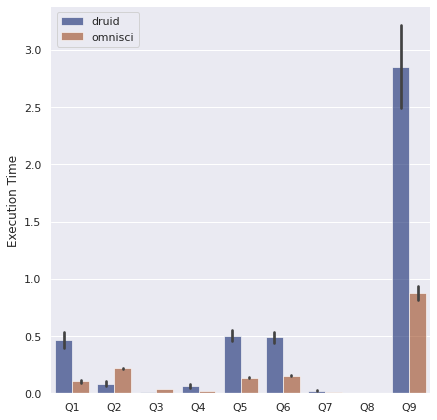

In [70]:
g = sns.catplot(
    data=data_DO, kind="bar",
    x="Query_ID", y="ExecutionTime", hue="Context",
    ci="sd", palette="dark", alpha=.6, height=6, legend=False
)

g.despine(left=True)
g.set_axis_labels("", "Execution Time")
plt.legend(loc='upper left')
g.savefig("../plots/queries_execution.png", dpi=100, bbox_inches='tight', pad_inches=0.1)

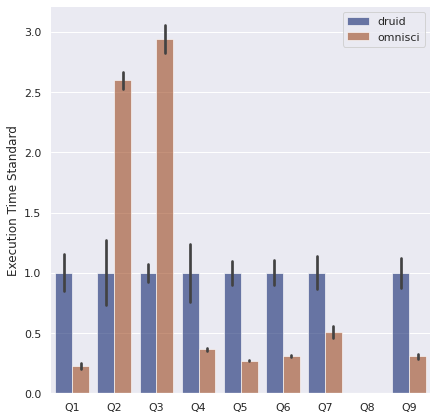

In [71]:
g = sns.catplot(
    data=data_DO, kind="bar",
    x="Query_ID", y="ExecutionTimeSTD", hue="Context",
    ci="sd", palette="dark", alpha=.6, height=6, legend=False
)

g.despine(left=True)
g.set_axis_labels("", "Execution Time Standard")
plt.legend(loc='upper right')
g.savefig("../plots/queries_execution_standardized.png", dpi=100, bbox_inches='tight', pad_inches=0.1)

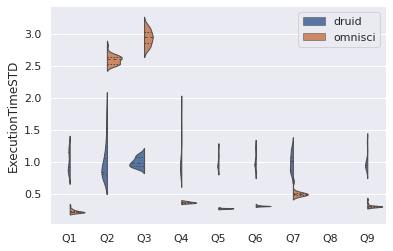

In [108]:
g = sns.violinplot(data=data_DO, x="Query_ID", y="ExecutionTimeSTD", hue="Context",
               split=True, inner="quart", linewidth=1)
sns.despine(left=True)
g.set(xlabel=None)
g.legend_.set_title(None)
g.get_figure().savefig("../plots/violin_plot.png", dpi=100, bbox_inches='tight', pad_inches=0.1)

In [103]:
data_DP = pd.DataFrame(columns=['Query_ID', 'ExecutionTime', 'Context'])

In [104]:
for context in ["druid", "pandas", "cudf"]:
    for query in ["Q1","Q3"]:
        for timing in test_result["timings"][context][query]:
            data_DP = data_DP.append({'Query_ID': query, 'ExecutionTime': timing, 'Context': context}, ignore_index=True)
data_DP

,Query_ID,ExecutionTime,Context
0,Q1,0.420828,druid
1,Q1,0.394000,druid
2,Q1,0.576804,druid
3,Q1,0.384480,druid
4,Q1,0.563681,druid
...,...,...,...
175,Q3,0.007002,cudf
176,Q3,0.007831,cudf
177,Q3,0.006744,cudf
178,Q3,0.008370,cudf


In [105]:
for x, group in data_DP.groupby("Query_ID"):
    group_mean = group.query("Context == 'pandas'")["ExecutionTime"].mean()
    group = group.eval("ExecutionTimeSTD = ExecutionTime / @group_mean")
    data_DP.loc[group.index, "ExecutionTimeSTD"] = group["ExecutionTimeSTD"]

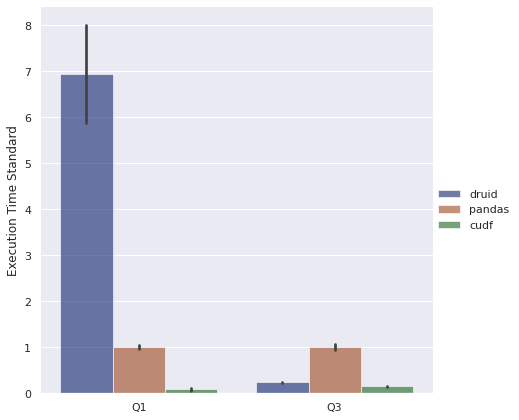

In [106]:
g = sns.catplot(
    data=data_DP, kind="bar",
    x="Query_ID", y="ExecutionTimeSTD", hue="Context",
    ci="sd", palette="dark", alpha=.6, height=6
)

g.despine(left=True)
g.set_axis_labels("", "Execution Time Standard")
g.legend.set_title("")
g.savefig("../plots/queries_execution_druid_pandas_standardized.png", dpi=100, bbox_inches='tight', pad_inches=0.1)

In [79]:
for query in test_result["queries"].keys():
    if query != "Q8":
    filtered_df = data_DO.query("Query_ID == @query")
    results_lm = ols('ExecutionTime ~ C(Context, Sum)', data=filtered_df).fit()
    table = sm.stats.anova_lm(results_lm, typ=2)
    print(f"\t{query}\n{table}\n")

	Q1
                   sum_sq    df           F        PR(>F)
C(Context, Sum)  1.961241   1.0  714.855693  2.625831e-34
Residual         0.159126  58.0         NaN           NaN

	Q2
                   sum_sq    df           F        PR(>F)
C(Context, Sum)  0.268404   1.0  951.463172  1.126033e-37
Residual         0.016362  58.0         NaN           NaN

	Q3
                   sum_sq    df            F        PR(>F)
C(Context, Sum)  0.007933   1.0  5994.111277  3.051313e-60
Residual         0.000077  58.0          NaN           NaN

	Q4
                   sum_sq    df          F        PR(>F)
C(Context, Sum)  0.024033   1.0  199.62092  1.961651e-20
Residual         0.006983  58.0        NaN           NaN

	Q5
                   sum_sq    df            F        PR(>F)
C(Context, Sum)  2.020496   1.0  1516.749414  2.795801e-43
Residual         0.077263  58.0          NaN           NaN

	Q6
                   sum_sq    df            F        PR(>F)
C(Context, Sum)  1.695106   1.0  1278.2